# Sequence to Sequence with CTC
This notebook show how to use CTC loss on Pytorch > 1.x, also I'm doing the same on tensorflow (1.13) to compare the same model on both libraries.

This kind of model is different from the encoder/decoder architecture, on this case we just have one encoder and the allignment is learn on the CTC loss, also it's also valid to remember that we need the CTC in inference time as well.

#### References
* https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c
* https://discuss.pytorch.org/t/lstm-ctc-model-not-learning-in-pytorch/48921/3
* https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_nn.html
* https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e
* https://blog.floydhub.com/gru-with-pytorch/
* https://distill.pub/2017/ctc/
* https://github.com/githubharald/CTCDecoder/tree/master/src

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf;
import tensorflow.keras as keras;
from tensorflow.keras.layers import Dense, Bidirectional, Dropout, Flatten, TimeDistributed, Lambda, LSTM;
from tensorflow.keras import Input, layers;
from tensorflow.keras import backend as K;
print('Tensorflow version:', tf.__version__)

from utils_tf_seq import ctcLoss
from utils_tf_seq import logProb
from utils_tf_seq import editDistance

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from np_dataset import NPDataset
import torch.utils.data as utils
print('Pytorch version:', torch.__version__)

# Load dataset
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)
vocab_size = 4
batch_size = 20

dataset_X = [data[0] for data in dataset]
dataset_Y = [data[1] for data in dataset]
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_Y, test_size=0.2)
X_train = np.expand_dims(np.array(X_train), axis=2)
X_test = np.expand_dims(np.array(X_test), axis=2)
y_train = np.array(y_train)
y_test = np.array(y_test)
print('Input sequence shape:', X_train.shape)
print('Label shape:', y_train.shape)
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_train = dataset_train.shuffle(100).batch(batch_size)
dataset_val = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_val = dataset_val.batch(batch_size)

Tensorflow version: 1.14.0
Pytorch version: 1.3.1
Input sequence shape: (320, 151, 1)
Label shape: (320, 15)


### Tensorflow

#### Define The Model
On Keras the LSTM input shape is (batch_size, timesteps, input_dim), now the output depends on the return_sequence this argument tells whether to return the output at each time step instead of the final time step.

In [2]:
model = tf.keras.Sequential([    
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True), merge_mode='concat'),      
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=vocab_size+1, activation='softmax'))
])    

model.compile(loss=[ctcLoss],
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[ctcLoss, logProb, editDistance])
model.build(input_shape=[None,151,1])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  25344     
_________________________________________________________________
time_distributed (TimeDistri multiple                  645       
Total params: 25,989
Trainable params: 25,989
Non-trainable params: 0
_________________________________________________________________


#### Train

In [3]:
H = model.fit(dataset_train, validation_data=dataset_val, epochs=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Epoch 1/10
16/16 [==============================] - 3s 206ms/step - loss: 50.9361 - ctcLoss: 50.9361 - logProb: 1212.8590 - editDistance: 18.2542 - val_loss: 34.7192 - val_ctcLoss: 34.7192 - val_logProb: 665.2933 - val_editDistance: 18.8000
Epoch 2/10
16/16 [==============================] - 2s 112ms/step - loss: 35.4048 - ctcLoss: 35.4048 - logProb: 535.3748 - editDistance: 18.8250 - val_loss: 32.1858 - val_ctcLoss: 32.1858 - val_logProb: 527.9349 - val_editDistance: 18.8000
Epoch 3/10
16/16 [==============================] - 2s 111ms/step - loss: 32.2751 - ctcLoss: 32.2751 - logProb: 495.2066 - editDistance: 18.8250 - val_loss: 29.0602 - val_ctcLoss: 29.0602 - val_logProb: 548.9796 - val_editDistance: 18.6667
Epoch 4/10
16/16 [==============================] - 2s 110ms/step - loss: 28.7346 - ct

#### Display Loss

<Figure size 432x288 with 0 Axes>

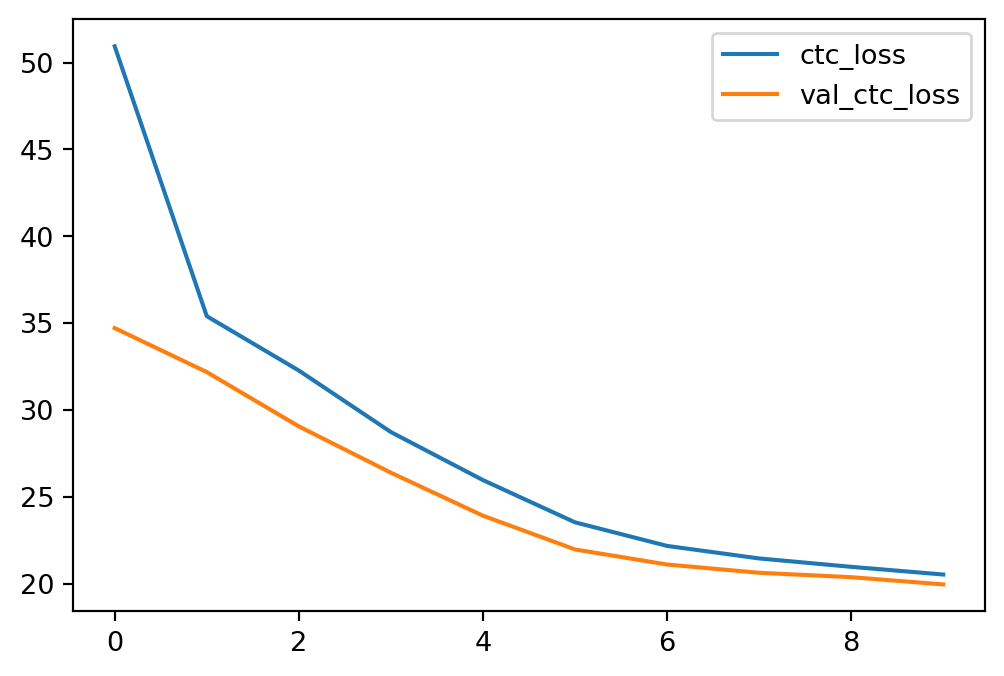

In [4]:
plt.clf();
plt.figure(dpi=196, figsize=(6,4))
plt.plot(H.history['ctcLoss'], '-', label='ctc_loss')
plt.plot(H.history['val_ctcLoss'], '-', label='val_ctc_loss')
plt.legend()

### Pytorch

On Pytorch the LSTM/GRU cells input shape are (seq_len, batch_size, input_dim), but if the parameter batch_first is True it will be (batch_size, seq_len, input_dim)

In [5]:
class Seq2SeqCTC(nn.Module):
    def __init__(self, input_dim, hidden_size, num_classes):
        super(Seq2SeqCTC, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_size, num_layers=1, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.bidirectional = 0
        
    def init_hidden(self, batch_size, device):
        if self.bidirectional:
            num_directions=2
        else:
            num_directions=1
        return torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_size, device=device)

    def forward(self, x):        
        B, T = x.shape[0], x.shape[1]
        x, hidden = self.gru(x)
        x = self.out(x)    
        # PAY attention to the dimension.... [BATCH, INPUT_SEQ, NUM_CLASSES]        
        return F.log_softmax(x, dim=1)

In [6]:
model = Seq2SeqCTC(1,64, vocab_size)

In [7]:
dataset_train = NPDataset(X_train, y_train)
dataloader_train = utils.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_val = NPDataset(X_test, y_test)
dataloader_val = utils.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [8]:
def train(model, dataloader_train, dataloader_val, device, epochs=10):
    losses = []
    val_losses = []
  
    # create a stochastic gradient descent optimizer
    optimizer = optim.Adam(model.parameters())
    optimizer.zero_grad()
  
    # ctc loss
    # (input, target, input_lengths, target_lengths)
    ctc_loss = nn.CTCLoss()
      
    # Iterate over epochs
    for epoch in range(epochs):
        model.init_hidden(batch_size, device)

        if epoch % (epochs//10)==0:
            print("Epoch #{}".format(epoch))

        # Training loop
        model.train()
        for batch_idx, sample in enumerate(dataloader_train):

            data = sample['X'].type(torch.float32)
            targets = sample['Y'].type(torch.int32)
            logits = model(data)
            
            # Get input/target lenghts for ctc_loss
            input_lengths = data.shape[1] * torch.ones(batch_size).type(torch.int32)
            target_lengths = targets.shape[1] * torch.ones(batch_size).type(torch.int32)

            # CTCLoss expects logits to be of shape (timesteps, batch_size, num_classes)
            loss = ctc_loss(logits.transpose(0,1), targets, input_lengths, target_lengths)
      
            optimizer.zero_grad()
            loss.backward() # Calculates derivatives with autograd
            optimizer.step() # Update weights

            # Append loss
            losses.append(loss.detach().cpu().numpy())

        # Validation loop
        model.eval()
        with torch.no_grad():
            for batch_idx, sample in enumerate(dataloader_val):
                data_val = sample['X'].type(torch.float32)
                targets_val = sample['Y'].type(torch.int32)
                logits_val = model(data_val)
                
                # Get input/target lenghts for ctc_loss
                input_lengths = data.shape[1] * torch.ones(batch_size).type(torch.int32)
                target_lengths = targets.shape[1] * torch.ones(batch_size).type(torch.int32)

                # CTCLoss expects logits to be of shape (timesteps, batch_size, num_classes)
                val_loss = ctc_loss(logits_val.transpose(0,1), targets_val, input_lengths, target_lengths)                            
                # Append val_loss
                val_losses.append(val_loss.detach().cpu().numpy())
  
    history = {'loss': losses, 'val_loss': val_losses}
    return history

In [9]:
history = train(model, dataloader_train, dataloader_val, 'cpu', epochs=100)

Epoch #0
Epoch #10
Epoch #20
Epoch #30
Epoch #40
Epoch #50
Epoch #60
Epoch #70
Epoch #80
Epoch #90


<Figure size 432x288 with 0 Axes>

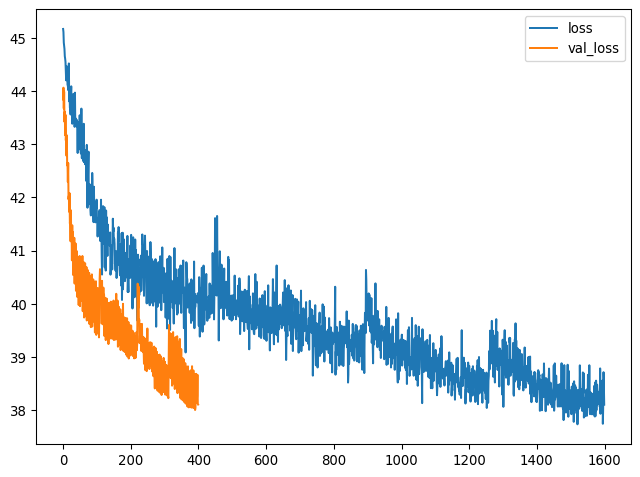

In [10]:
plt.clf();
plt.figure(figsize=(8,6), dpi=96)
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

#### Decode

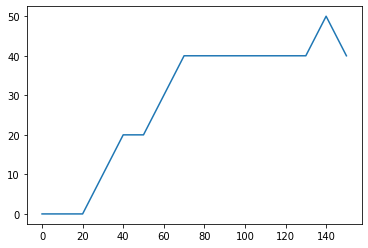

indices: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
label: [3 3 1 1 3 1 1 3 3 3 3 3 3 1 2]


In [33]:
input_signal = dataset_val[0]['X']
label = dataset_val[0]['Y']
plt.plot(input_signal)
plt.show()
input_signal = torch.tensor(input_signal).unsqueeze(0).type(torch.float32)
model.eval()
result_not_allign = model(input_signal)
_, indices = torch.max(result_not_allign, 2)
indices = indices.tolist()[0]
# Take CTC blank
indices = [x for x in indices if x != 0]
print('indices:', indices)
print('label:', label)